<a href="https://colab.research.google.com/github/babybulat/ml-in-aesc-trial/blob/main/crossentropy_method_practice_easy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
import os

In [2]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
env.render()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist

In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [4]:
policy =np.full((n_states, n_actions), 1./n_actions)
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [5]:
def generate_session(policy,t_max=500):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        a = np.random.choice(range(n_actions), p = policy[s])

        new_s,r,done,info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward+=r

        s = new_s
        if done:
            break
    return states,actions,total_reward


In [8]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float]

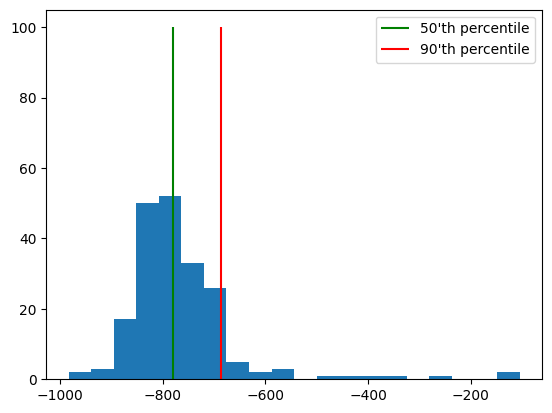

In [9]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [12]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    reward_threshold = np.percentile(rewards_batch,percentile)
    elite_indexes= []
    for i in range(rewards_batch.size):
      if(rewards_batch[i]>=reward_threshold):
        elite_indexes.append(i)

    elite_states = []
    elite_actions = []

    for i in range(len(elite_indexes)):
      elite_states.extend(states_batch[elite_indexes[i]])
    for i in range(len(elite_indexes)):
      elite_actions.extend(actions_batch[elite_indexes[i]])


    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)

    return elite_states,elite_actions


In [13]:
states_batch = ([
    np.array([1,2,3]),   #game1
    np.array([4,2,0,2]), #game2
    np.array([3,1])      #game3
])

actions_batch = ([
    np.array([0,2,4]),   #game1
    np.array([3,2,0,1]), #game2
    np.array([3,3])      #game3
])
rewards_batch = np.array([
    3,         #game1
    4,         #game2
    5,         #game3
])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_30 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)


assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_30[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [14]:
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states,n_actions])

    for i in range(len(elite_states)):
      new_policy[elite_states[i]][elite_actions[i]]+=1
    for i in range(n_states):
      sum_row=np.sum(new_policy[i])
      if(sum_row==0):
        new_policy[i].fill(1/n_actions)
      else:
        new_policy[i]=new_policy[i]/sum_row

    return new_policy

In [15]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log,percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [ ]:
policy = np.full((n_states, n_actions), 1.0 / n_actions)


mean reward = -305.240, threshold=7.000


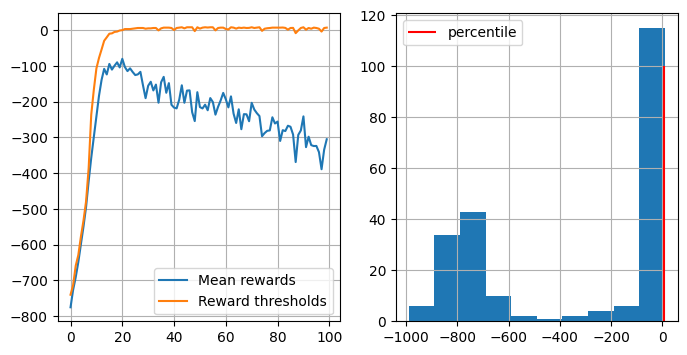

In [ ]:
n_sessions = 250  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):

    %time sessions = [generate_session(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile)

    new_policy = update_policy(elite_states,elite_actions)

    policy = new_policy*learning_rate+(1-learning_rate)*policy

    #display results on chart
    show_progress(rewards_batch,log,percentile)

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [ ]:

import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
env.render()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy =np.full((n_states, n_actions), 1./n_actions)
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]
policy =np.full((n_states, n_actions), 1./n_actions)

AttributeError: module 'numpy' has no attribute 'bool8'

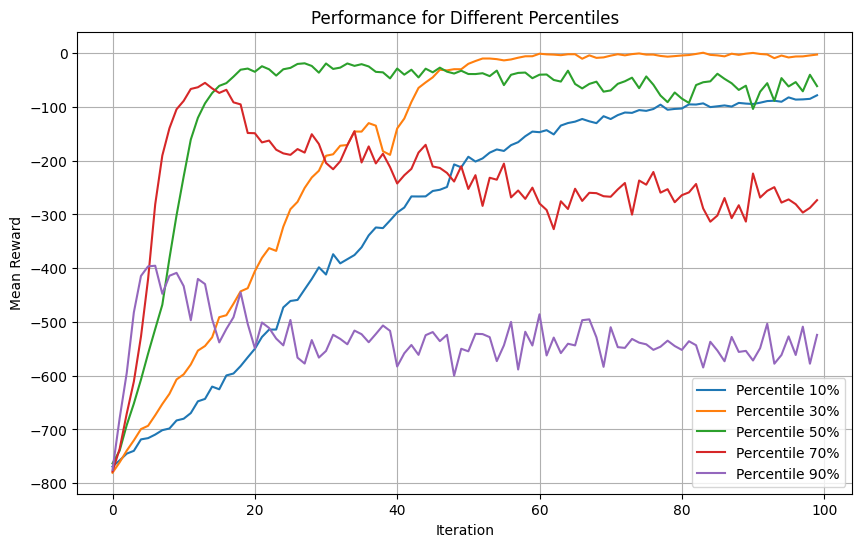

In [ ]:
stepCounter = 100
n_sessions = 250  #sample this many sessions
percentiles = [10,30,50,70,90]  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability


mean = []
for percentile in percentiles:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions

    log = []
    for i in range(stepCounter):

        %time sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile)

        new_policy = update_policy(elite_states,elite_actions)

        policy = new_policy*learning_rate+(1-learning_rate)*policy

        show_progress(rewards_batch,log,percentile)

        curMean.append(np.mean(rewards_batch))

        clear_output(True)
    mean.append(curMean)
    #display results on chart
plt.figure(figsize=(10, 6))
for i, percentile in enumerate(percentiles):
    plt.plot(range(stepCounter), mean[i], label=f'Percentile {percentile}%')

plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.title('Performance for Different Percentiles')
plt.legend()
plt.grid(True)
plt.show()


# How do different percentiles affect training efficiency?

Лучшее средняя награда через 40 итераций получается при проценте равным 30.

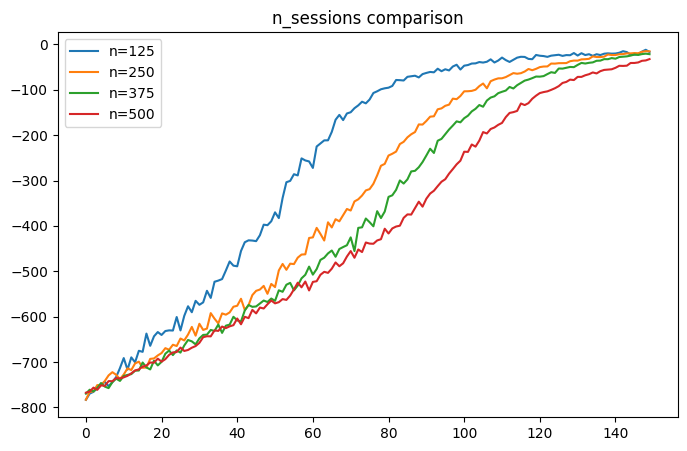

In [ ]:
n_sessions_ar = [125,250,375,500]  #sample this many sessions
percentile = 30  #take this percent of session with highest rewards
learning_rate = 0.1  #add this thing to all counts for stability


mean = []
for n_sessions in n_sessions_ar:
    log = []
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(150):

        %time sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile)

        new_policy = update_policy(elite_states,elite_actions)

        policy = new_policy*learning_rate+(1-learning_rate)*policy

        show_progress(rewards_batch,log,percentile)

        curMean.append(np.mean(rewards_batch))
        clear_output(True)
    mean.append(curMean)
    #display results on chart
    #show_progress(rewards_batch,log)
plt.figure(figsize=(8, 5))
for i, n in enumerate(n_sessions_ar):
    plt.plot(mean[i], label=f'n={n}')
plt.legend()
plt.title('n_sessions comparison')
plt.show()



# Stabilize positive rewards by averaging policy across 10 games (2 pts)

In [ ]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.

    #code here
    return states,actions,total_reward


mean reward = 7.084, threshold=4.000


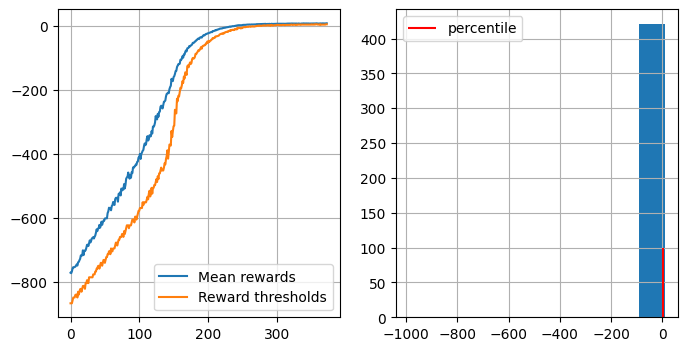

win!


In [17]:
n_sessions = 500  #sample this many sessions
percentile = 10   #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
for i in range(500):

    %time sessions = [generate_session(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile)

    #code here
    new_policy = update_policy(elite_states,elite_actions)

    policy = new_policy*learning_rate+(1-learning_rate)*policy

    show_progress(rewards_batch,log,percentile)

    if(np.mean(rewards_batch) > 7):
        print("win!")
        break

# Digging deeper: approximate crossentropy with neural nets (2 pts)

In this section we will train a neural network policy for continuous state space game

/usr/local/lib/python3.12/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for

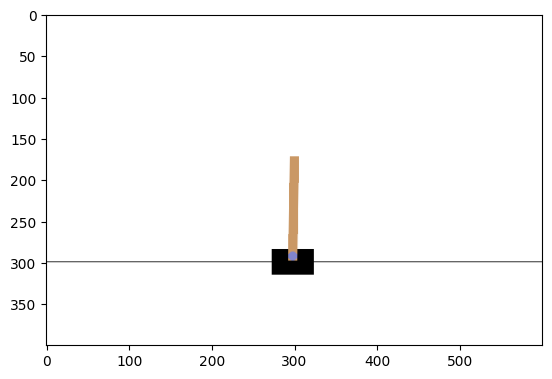

In [29]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make("CartPole-v0").env  #if you see "<classname> has no attribute .env", remove .env or update gym

env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In this case use NN as a black box. All your should know that it is more complex than a tabular method.

In [30]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [31]:
def generate_session(t_max=1000):

    states,actions = [],[]
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        #predict array of action probabilities hint: predict_proba
        probs = agent.predict_proba([s])[0]

        a = np.random.choice(np.arange(n_actions), p=probs)

        new_s,r,done,info = env.step(a)

        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done: break
    return states,actions,total_reward


In [37]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    reward_threshold = np.percentile(rewards_batch,percentile)
    elite_indexes= []
    for i in range(rewards_batch.size):
      if(rewards_batch[i]>=reward_threshold):
        elite_indexes.append(i)

    elite_states = []
    elite_actions = []

    for i in range(len(elite_indexes)):
      elite_states.extend(states_batch[elite_indexes[i]])
    for i in range(len(elite_indexes)):
      elite_actions.extend(actions_batch[elite_indexes[i]])



    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)

    return elite_states,elite_actions


To train this classification model use fit(states, actions). In this case we are training classificator to predict the correct class (action) in a given state

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


mean reward = 242.480, threshold=275.100


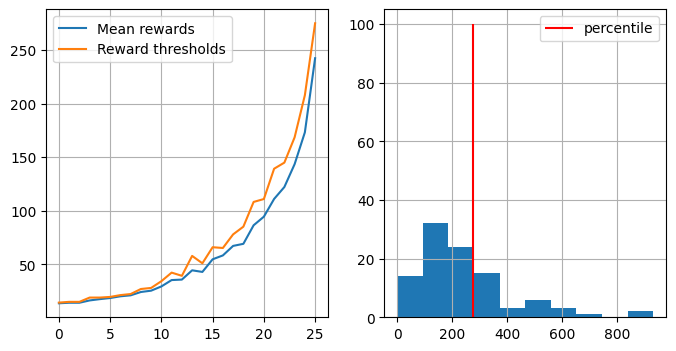

You Win! You may stop training now via KeyboardInterrupt.


In [38]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    #states_batch,actions_batch,rewards_batch = map(np.array,zip(*sessions))
    states_batch,actions_batch,rewards_batch = zip(*sessions)
    #print(states_batch.shape)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,np.array(rewards_batch),percentile)

    #fit agent
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,percentile,reward_range=[0,np.max(rewards_batch)])

    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Report (1 pts)

In [ ]:
# Describe what you did here.  Preferably with plot/report to support it

В этом домашнем задании мы попробовали обучить  методом кроссентропии на модели Taxi-v3 и CartPole-v0. В перовой модели нужно было задать n_sessions=500, percentile = 30 и learnig_rate=0.3 для того чтобы получить среднюю награду > 7. Во второй модели было достаточно percentile=70 и n_sessions=100. Это мы поняли пробую задать разные значения констнат и анализируя графики резултатов.